# Temperature and humidity calibation - Unsupervised learning

In [1]:
# to access the data on google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import datetime

import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from scipy.cluster import hierarchy

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

# supress unnecessary warning msgs
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
df_raw = pd.read_csv("/content/drive/MyDrive/propulsion/Final_Project/data/processed/merged_data.csv", parse_dates=["time"])

In [4]:
# change source_address to categorical
df_raw["source_address"] = df_raw["source_address"].astype("category")

In [5]:
# drop the period when and around the time the lamps were unplugged
df = df_raw[(df_raw["time"] < "2022-09-16") | (df_raw["time"] > "2022-09-20")]

In [6]:
dflamp = df[df["device_type"]=="lamp"]
dflamp

,time,source_address,light_state,local_detections,sht40_humidity,sht40_temperature,shtc3_humidity,shtc3_temperature,total_normalized_energy,wsen_pads_temperature,x_position,y_position,z_position,device_type,energy_per_period,detect_per_period,time_diff
7,2022-08-15 00:00:48.836,856134660,2.0,13815.0,25.86,34.49,NaN,NaN,173679.0,34.71,259,15,0,lamp,NaN,NaN,NaN
8,2022-08-15 00:00:48.854,2050868026,2.0,17776.0,25.69,34.77,NaN,NaN,226070.0,34.62,215,15,0,lamp,NaN,NaN,NaN
9,2022-08-15 00:00:48.857,1629094469,2.0,15988.0,25.62,34.73,NaN,NaN,167885.0,34.70,155,15,0,lamp,NaN,NaN,NaN
10,2022-08-15 00:00:48.862,160784073,2.0,23565.0,25.74,34.18,NaN,NaN,219515.0,34.44,230,15,0,lamp,NaN,NaN,NaN
11,2022-08-15 00:00:48.867,730804714,2.0,24510.0,26.12,34.48,NaN,NaN,250216.0,34.86,170,15,0,lamp,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171728,2022-10-05 23:59:11.433,2062404276,2.0,27476.0,24.66,35.65,NaN,NaN,289466.0,36.57,111,15,0,lamp,0.0,0.0,1.0
1171729,2022-10-05 23:59:11.437,465407368,2.0,23750.0,25.08,35.58,NaN,NaN,278181.0,35.82,245,15,0,lamp,0.0,0.0,1.0
1171730,2022-10-05 23:59:11.439,367818600,2.0,27551.0,24.33,35.50,NaN,NaN,352791.0,35.77,185,15,0,lamp,0.0,0.0,1.0
1171731,2022-10-05 23:59:11.444,2050868026,2.0,23860.0,23.76,35.93,NaN,NaN,324802.0,35.79,215,15,0,lamp,0.0,0.0,1.0


In [7]:
# drop the columns that are constant or missing
dflamp_c = dflamp.drop(["shtc3_humidity", "shtc3_temperature", "y_position", "z_position", "device_type"], axis=1).sort_values(["time", "source_address"], ascending=True)
dflamp_c.describe()

,light_state,local_detections,sht40_humidity,sht40_temperature,total_normalized_energy,wsen_pads_temperature,x_position,energy_per_period,detect_per_period,time_diff
count,786314.000000,786314.000000,786314.000000,786314.000000,786314.000000,786314.000000,786314.000000,786303.000000,786303.000000,786303.000000
mean,1.887722,22515.587541,26.805700,35.518452,258633.826339,35.859271,185.000764,1.403060,0.115943,0.852028
std,0.409535,5931.679346,4.545584,0.790691,46784.262905,0.826187,47.147883,4.754215,0.657681,0.360663
min,0.000000,11604.000000,15.030000,33.220000,161491.000000,33.530000,111.000000,-111.000000,-26.000000,0.000000
25%,2.000000,18353.000000,23.430000,34.960000,224219.000000,35.280000,140.000000,0.000000,0.000000,1.000000
50%,2.000000,21497.000000,27.100000,35.490000,256591.000000,35.840000,185.000000,0.000000,0.000000,1.000000
75%,2.000000,26464.000000,30.500000,36.010000,290389.000000,36.400000,230.000000,0.000000,0.000000,1.000000
max,5.000000,37647.000000,37.480000,38.950000,382993.000000,39.360000,259.000000,105.000000,24.000000,5.000000


In [8]:
dflamp_c[dflamp_c["energy_per_period"]<0]

,time,source_address,light_state,local_detections,sht40_humidity,sht40_temperature,total_normalized_energy,wsen_pads_temperature,x_position,energy_per_period,detect_per_period,time_diff
108209,2022-08-18 15:06:20.061,730804714,2.0,26153.0,31.16,35.69,263049.0,36.05,170,-39.0,-1.0,0.0
702469,2022-09-08 22:06:16.494,1629094469,2.0,20520.0,26.53,34.99,222947.0,34.92,155,-6.0,0.0,1.0
807193,2022-09-14 07:17:23.956,1629094469,2.0,21825.0,30.68,35.99,235795.0,35.88,155,-16.0,0.0,3.0
807195,2022-09-14 07:17:40.721,730804714,2.0,33004.0,31.34,35.56,321866.0,35.93,170,-1.0,0.0,1.0
807206,2022-09-14 07:18:41.070,2062404276,2.0,23386.0,30.94,36.29,246376.0,37.18,111,-2.0,0.0,3.0
1143426,2022-10-04 14:33:01.011,1307336718,1.0,36536.0,22.25,37.20,378298.0,37.76,200,-6.0,0.0,2.0
1143441,2022-10-04 14:35:50.918,367818600,2.0,27200.0,23.02,36.49,348389.0,36.65,185,-14.0,0.0,5.0
1143442,2022-10-04 14:35:51.742,924241205,2.0,19297.0,23.16,36.59,277266.0,37.29,140,-103.0,-14.0,2.0
1143444,2022-10-04 14:35:56.143,1629094469,2.0,25609.0,22.81,36.77,278669.0,36.67,155,-25.0,0.0,5.0
1143449,2022-10-04 14:36:27.201,362609437,2.0,21242.0,23.24,36.82,314037.0,37.20,125,-111.0,-26.0,1.0


In [9]:
dflamp_c[(dflamp_c["time"]>"2022-10-04 14:33:00")].head(12)

,time,source_address,light_state,local_detections,sht40_humidity,sht40_temperature,total_normalized_energy,wsen_pads_temperature,x_position,energy_per_period,detect_per_period,time_diff
1143426,2022-10-04 14:33:01.011,1307336718,1.0,36536.0,22.25,37.20,378298.0,37.76,200,-6.0,0.0,2.0
1143431,2022-10-04 14:33:48.839,924241205,1.0,19311.0,22.83,36.82,277369.0,37.63,140,50.0,7.0,2.0
1143433,2022-10-04 14:34:48.704,362609437,0.0,21268.0,23.02,36.98,314148.0,37.34,125,29.0,2.0,2.0
1143434,2022-10-04 14:34:48.744,2050868026,0.0,23563.0,21.49,37.75,320875.0,37.53,215,28.0,5.0,3.0
1143435,2022-10-04 14:34:48.745,856134660,0.0,20217.0,21.85,37.23,251326.0,37.45,259,13.0,0.0,2.0
1143437,2022-10-04 14:35:19.703,1307336718,2.0,36536.0,22.46,36.99,378303.0,37.50,200,5.0,0.0,2.0
1143438,2022-10-04 14:35:19.704,730804714,2.0,37136.0,22.97,36.76,366979.0,37.07,170,17.0,-1.0,4.0
1143439,2022-10-04 14:35:48.673,160784073,2.0,33354.0,21.00,37.45,311484.0,37.67,230,33.0,6.0,4.0
1143440,2022-10-04 14:35:48.753,2050868026,2.0,23563.0,21.63,37.73,320880.0,37.51,215,5.0,0.0,1.0
1143441,2022-10-04 14:35:50.918,367818600,2.0,27200.0,23.02,36.49,348389.0,36.65,185,-14.0,0.0,5.0


In [10]:
# drop data error (the rows with negative values from the two new features above)
dflamp_d = dflamp_c[(dflamp_c["energy_per_period"]>=0) & (dflamp_c["detect_per_period"]>=0)]
dflamp_d.describe()

,light_state,local_detections,sht40_humidity,sht40_temperature,total_normalized_energy,wsen_pads_temperature,x_position,energy_per_period,detect_per_period,time_diff
count,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000
mean,1.887723,22515.584449,26.805737,35.518448,258633.965520,35.859267,185.001068,1.403611,0.116027,0.851997
std,0.409533,5931.662307,4.545625,0.790681,46783.856567,0.826175,47.147908,4.749618,0.656550,0.360538
min,0.000000,11604.000000,15.030000,33.220000,161491.000000,33.530000,111.000000,0.000000,0.000000,0.000000
25%,2.000000,18353.000000,23.430000,34.960000,224219.000000,35.280000,140.000000,0.000000,0.000000,1.000000
50%,2.000000,21497.000000,27.100000,35.490000,256591.000000,35.840000,185.000000,0.000000,0.000000,1.000000
75%,2.000000,26464.000000,30.500000,36.010000,290389.000000,36.400000,230.000000,0.000000,0.000000,1.000000
max,5.000000,37647.000000,37.480000,38.950000,382993.000000,39.360000,259.000000,105.000000,24.000000,4.000000


In [11]:
# standardize the numeric columns
scaler = MinMaxScaler()
dflamp_s =dflamp_d.copy()
cols = ["light_state", "local_detections", "sht40_humidity", "sht40_temperature", "total_normalized_energy", "wsen_pads_temperature", "x_position", "energy_per_period", "detect_per_period", "time_diff"]
dflamp_s[cols] = scaler.fit_transform(dflamp_d[cols])


In [12]:
dflamp_s

,time,source_address,light_state,local_detections,sht40_humidity,sht40_temperature,total_normalized_energy,wsen_pads_temperature,x_position,energy_per_period,detect_per_period,time_diff
27,2022-08-15 00:01:48.831,856134660,0.4,0.084898,0.470379,0.223386,0.055024,0.202401,1.000000,0.0,0.0,0.00
28,2022-08-15 00:01:48.858,2050868026,0.4,0.236993,0.468597,0.265271,0.291550,0.186964,0.702703,0.0,0.0,0.25
29,2022-08-15 00:01:48.861,1629094469,0.4,0.168337,0.471715,0.272251,0.028867,0.200686,0.297297,0.0,0.0,0.25
30,2022-08-15 00:01:48.869,730804714,0.4,0.495565,0.494432,0.221640,0.400561,0.228130,0.398649,0.0,0.0,0.25
31,2022-08-15 00:01:48.872,160784073,0.4,0.459279,0.480178,0.160558,0.261957,0.154374,0.804054,0.0,0.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...
1171728,2022-10-05 23:59:11.433,2062404276,0.4,0.609454,0.428953,0.424084,0.577760,0.521441,0.000000,0.0,0.0,0.25
1171729,2022-10-05 23:59:11.437,465407368,0.4,0.466383,0.447661,0.411867,0.526812,0.392796,0.905405,0.0,0.0,0.25
1171730,2022-10-05 23:59:11.439,367818600,0.4,0.612333,0.414254,0.397906,0.863649,0.384220,0.500000,0.0,0.0,0.25
1171731,2022-10-05 23:59:11.444,2050868026,0.4,0.470606,0.388864,0.472949,0.737289,0.387650,0.702703,0.0,0.0,0.25


In [13]:
dflamp_s.describe()

,light_state,local_detections,sht40_humidity,sht40_temperature,total_normalized_energy,wsen_pads_temperature,x_position,energy_per_period,detect_per_period,time_diff
count,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000,786289.000000
mean,0.377545,0.418983,0.524532,0.401125,0.438565,0.399531,0.500007,0.013368,0.004834,0.212999
std,0.081907,0.227764,0.202478,0.137990,0.211212,0.141711,0.318567,0.045234,0.027356,0.090134
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.259148,0.374165,0.303665,0.283194,0.300172,0.195946,0.000000,0.000000,0.250000
50%,0.400000,0.379872,0.537639,0.396161,0.429341,0.396226,0.500000,0.000000,0.000000,0.250000
75%,0.400000,0.570595,0.689087,0.486911,0.581927,0.492281,0.804054,0.000000,0.000000,0.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


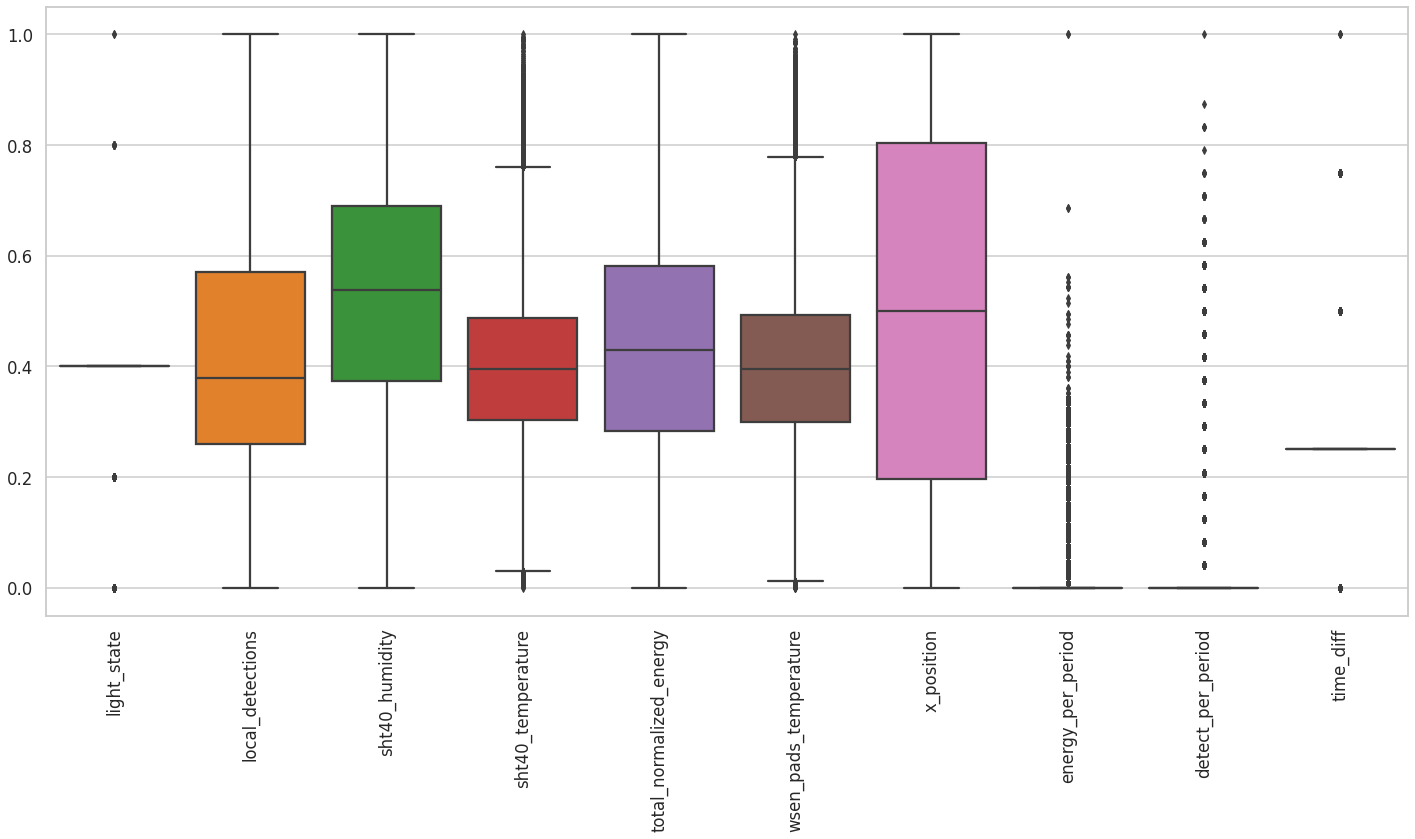

In [14]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.boxplot(ax=ax, data=dflamp_s, orient="v")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

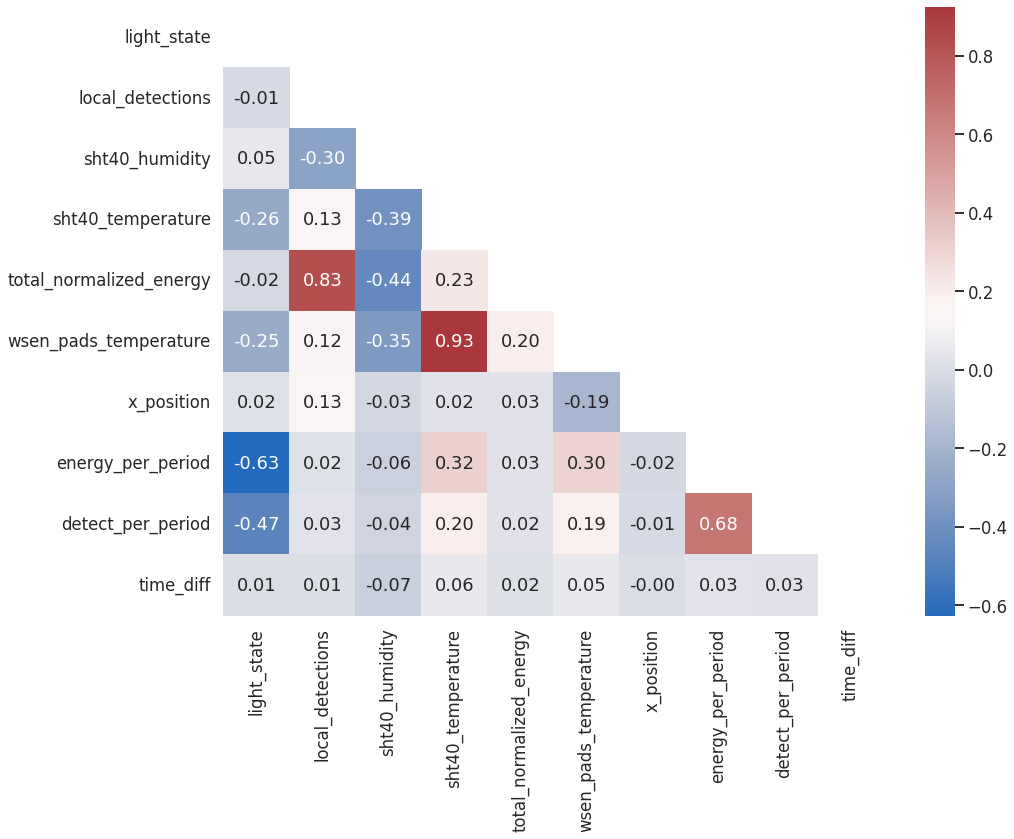

In [15]:
matrix = np.triu(dflamp_s.corr())
fig, ax = plt.subplots(figsize=(15, 12))
ax = sns.heatmap(dflamp_s.corr(), annot=True, fmt=".2f", mask=matrix, cmap="vlag")
plt.tight_layout()
plt.show()

In [16]:
dfsensor = df[df["device_type"]=="external_sensor"]
# keep only the columns that are nonmissing
dfsensor_c = dfsensor[["time", "source_address", "shtc3_humidity", "shtc3_temperature", "x_position"]].sort_values(["time", "source_address"], ascending=True)
dfsensor_c.describe()

,shtc3_humidity,shtc3_temperature,x_position
count,359619.000000,359619.000000,359619.000000
mean,55.470839,22.493024,182.970713
std,8.132258,0.740415,48.446110
min,29.480000,20.840000,111.000000
25%,51.090000,21.920000,147.000000
50%,56.910000,22.450000,185.000000
75%,61.240000,22.990000,215.000000
max,71.300000,26.280000,259.000000


In [17]:
dfsensor_c

,time,source_address,shtc3_humidity,shtc3_temperature,x_position
0,2022-08-15 00:00:15.986,1786944289,48.94,22.07,259
1,2022-08-15 00:00:25.205,614953587,49.73,21.82,125
2,2022-08-15 00:00:26.089,926036168,49.50,21.91,245
3,2022-08-15 00:00:34.707,2132706098,49.31,21.81,185
4,2022-08-15 00:00:35.290,2099571705,49.73,21.84,215
...,...,...,...,...,...
1171707,2022-10-05 23:57:19.632,2132706098,45.13,22.80,185
1171708,2022-10-05 23:57:57.031,926036168,45.72,22.81,245
1171709,2022-10-05 23:58:07.567,2099571705,45.73,22.79,215
1171721,2022-10-05 23:58:22.165,1566931549,46.30,22.73,155


# LAMPS

## K-means

In [18]:
# convert time to datetime then to integer, so that it can be used for clustering
dflamp_k = dflamp_d.copy()
dflamp_d["time"] = pd.to_datetime(dflamp_d["time"])
dflamp_k["tperiod"] = (dflamp_d["time"]>"2022-09-18").astype(int)
dflamp_k["timeint"] = dflamp_d["time"].values.astype(np.int64) // 10 ** 9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
dflamp_cluster = dflamp_k.copy()
dflamp_cluster = dflamp_k.drop(columns=["time"]).sample(n=20000, axis=0, random_state=18).reset_index(drop=True)
X = dflamp_cluster.values
X.shape

(20000, 13)

In [20]:
dflamp_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   source_address           20000 non-null  category
 1   light_state              20000 non-null  float64 
 2   local_detections         20000 non-null  float64 
 3   sht40_humidity           20000 non-null  float64 
 4   sht40_temperature        20000 non-null  float64 
 5   total_normalized_energy  20000 non-null  float64 
 6   wsen_pads_temperature    20000 non-null  float64 
 7   x_position               20000 non-null  int64   
 8   energy_per_period        20000 non-null  float64 
 9   detect_per_period        20000 non-null  float64 
 10  time_diff                20000 non-null  float64 
 11  tperiod                  20000 non-null  int64   
 12  timeint                  20000 non-null  int64   
dtypes: category(1), float64(9), int64(3)
memory usage: 1.9 MB


In [ ]:
ss = []
cluster_ranges = range(2, 9)

for K in cluster_ranges:
    # standardize the variables and fit a k-means model
    kmeans_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=K, random_state=18, n_init=100, max_iter=1000))])
    kmeans_pipeline.fit_predict(X)
    # stores the ss errors
    ss.append(kmeans_pipeline.named_steps["cluster"].inertia_)

## "Optimal" number of clusters (elbow and silhouette method)

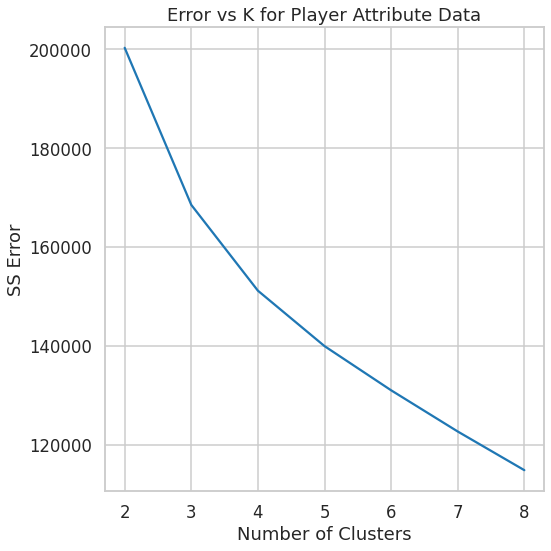

In [ ]:
# Elbow

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.lineplot(x=cluster_ranges, y=ss)
ax.set_title("Error vs K for Player Attribute Data")
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('SS Error')
plt.tight_layout()
plt.show()

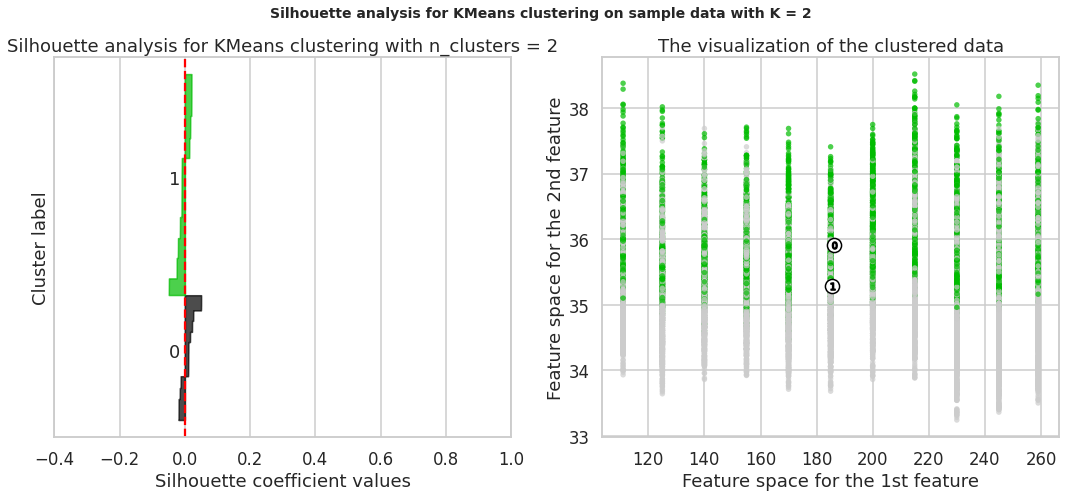

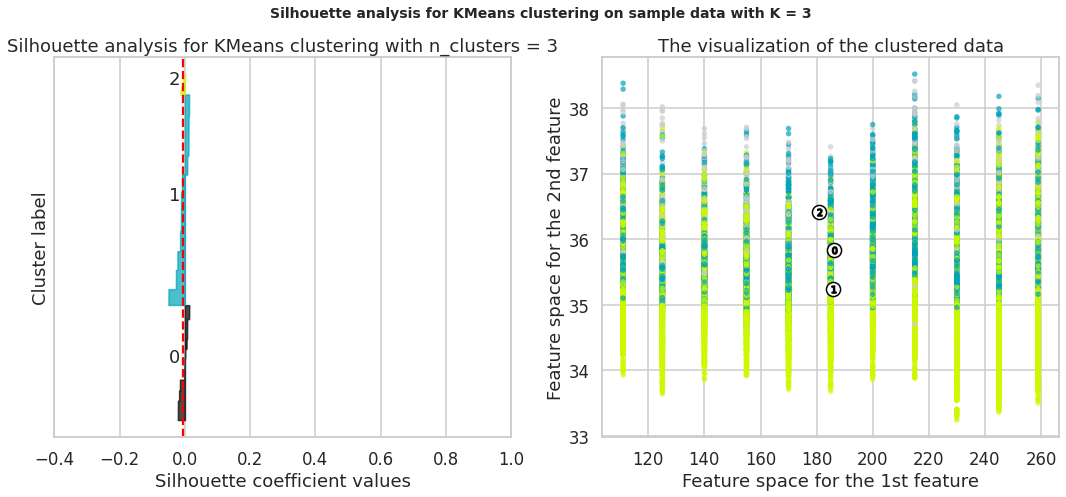

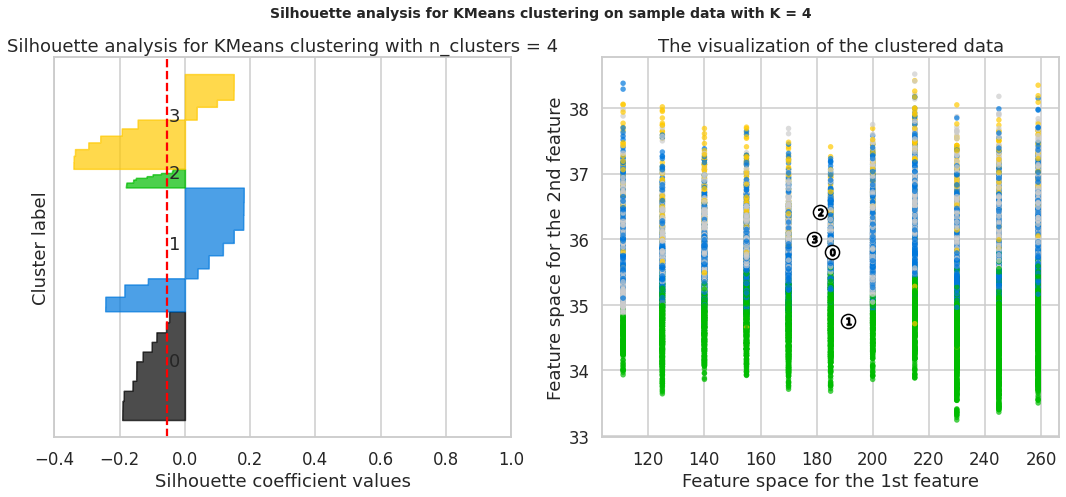

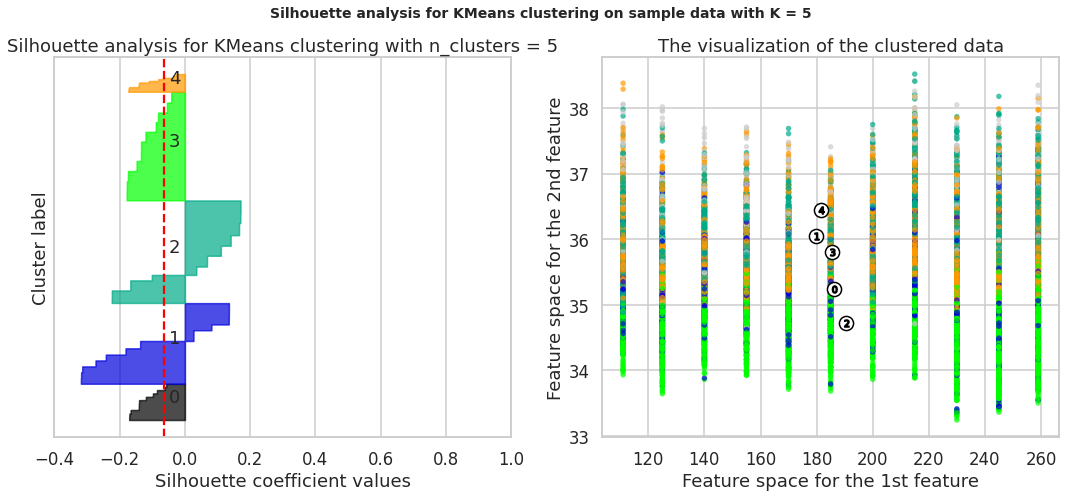

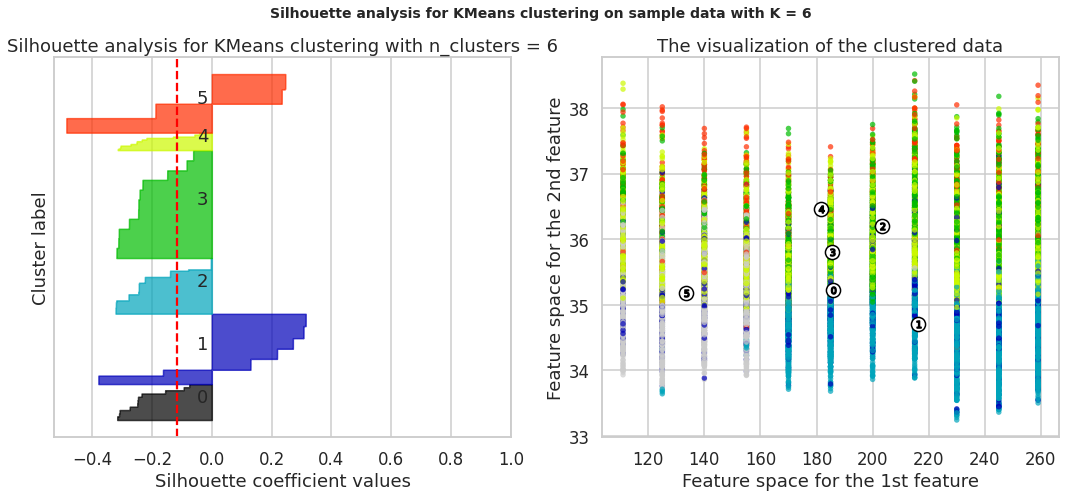

In [ ]:
# Silhouette method

# Code adapted from scikit-learn documentation example

avg_silhouette_scores = []
cluster_ranges = range(2, 7)

# Get rid of warning of too many plots open
plt.rcParams.update({'figure.max_open_warning': 0})

for K in cluster_ranges:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax.set_xlim([-.4, 1])
    # The (K+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility
    kmeans_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=K, random_state=18, n_init=100, max_iter=1000))])

    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = (silhouette_score(X, cluster_labels))
    avg_silhouette_scores.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"Silhouette analysis for KMeans clustering with n_clusters = {K}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / K)
    # to visualize the actual data in a continuous space we use PCA
    ax2.scatter(X[:, 7], X[:, 4], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 7], centers[:, 4], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[7], c[4], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        (
            f"Silhouette analysis for KMeans clustering on sample data with K = {K}"
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
 
plt.show()

From the elbow method, 3 clusters seem to be the best choice. However, the Silhouette method does not produce any clear indication.

## PCA



In [28]:
pca_cols = ["light_state", "sht40_humidity", "sht40_temperature", "total_normalized_energy", "detect_per_period", "time_diff"] 
dfpca = dflamp_cluster[pca_cols]
X = dfpca.values
X.shape

(20000, 6)

In [ ]:
# Standardize the variables first, then calculate top two PCA features
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_std)
x_pca = pca_features[:,0]
y_pca = pca_features[:,1]

K = 3   # use the 3 clusters from elbow method 

kmeans = KMeans(n_clusters=K, random_state=18, n_init=1000, max_iter=10000)
cl_labels = kmeans.fit_predict(X_std)
df_pca_features = pd.DataFrame({"cluster_id": cl_labels, 
                                "pc_1": x_pca, 
                                "pc_2": y_pca})
df_pca_features

,cluster_id,pc_1,pc_2
0,2,1.302249,-1.039404
1,0,-1.138907,0.060844
2,2,-0.185004,-0.616713
3,0,-2.328399,1.134296
4,0,-1.237824,0.311394
...,...,...,...
19995,0,-0.667711,0.466917
19996,0,-0.741076,0.338487
19997,0,0.728992,2.429820
19998,0,-1.141571,0.708226


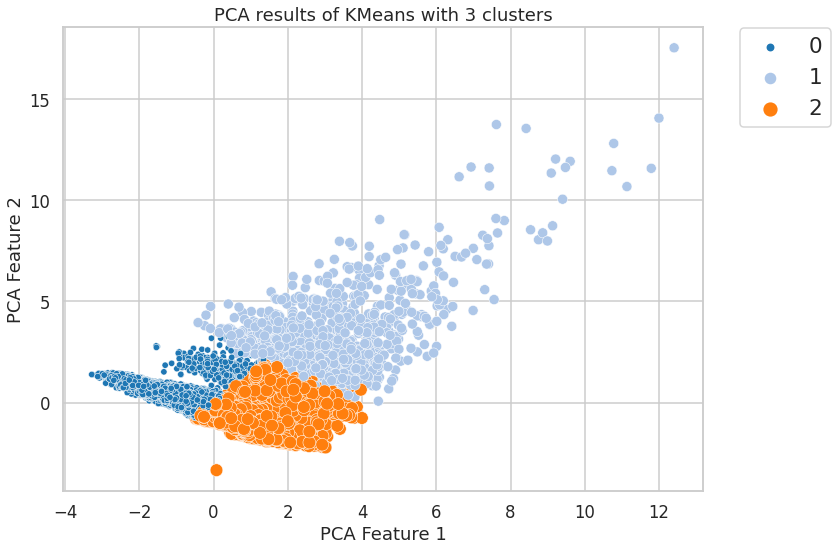

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(x="pc_1", y="pc_2", 
                hue="cluster_id", 
                size="cluster_id", 
                data=df_pca_features, 
                palette="tab20", 
                legend="full")
ax.set_xlabel("PCA Feature 1")
ax.set_ylabel("PCA Feature 2")
ax.set_title("PCA results of KMeans with " + str(K) + " clusters")
ax.legend(bbox_to_anchor=(1.04,1.02), loc="upper left", fontsize="large")
plt.tight_layout()
plt.show()

In [ ]:
# merge cluster to position dataframe
df_cluster = pd.concat([dflamp_cluster, pd.DataFrame(cl_labels, columns=["Cluster"])], axis=1)
df_cluster

,source_address,light_state,local_detections,sht40_humidity,sht40_temperature,total_normalized_energy,wsen_pads_temperature,x_position,energy_per_period,detect_per_period,time_diff,tperiod,timeint,Cluster
0,2062404276,2.0,24068.0,18.57,36.34,255930.0,37.24,111,1.0,0.0,1.0,1,1663654202,2
1,362609437,2.0,14093.0,25.77,34.32,224219.0,34.83,125,0.0,0.0,1.0,0,1661308509,0
2,2050868026,2.0,20486.0,24.18,34.81,275722.0,34.71,215,0.0,0.0,1.0,0,1662835360,2
3,1629094469,2.0,17256.0,32.88,34.25,181854.0,34.19,155,0.0,0.0,1.0,0,1660940573,0
4,2050868026,2.0,20125.0,33.62,34.85,269845.0,34.74,215,0.0,0.0,1.0,0,1662522601,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2062404276,2.0,21823.0,31.31,35.88,225158.0,36.79,111,0.0,0.0,1.0,0,1662285299,0
19996,2050868026,2.0,18211.0,30.81,35.56,235685.0,35.44,215,10.0,0.0,1.0,0,1660803352,0
19997,1629094469,2.0,19843.0,32.92,36.64,213087.0,36.63,155,14.0,2.0,1.0,0,1662461994,0
19998,856134660,2.0,15608.0,30.41,35.43,194607.0,35.67,259,0.0,0.0,1.0,0,1661711265,0


In [ ]:
df_cluster2 = df_cluster.groupby(["Cluster"]).mean()
df_cluster2

,light_state,local_detections,sht40_humidity,sht40_temperature,total_normalized_energy,wsen_pads_temperature,x_position,energy_per_period,detect_per_period,time_diff,tperiod,timeint
Cluster,,,,,,,,,,,,
0,1.977688,19907.936815,29.919371,35.100050,230576.559878,35.461308,184.381874,0.416132,0.013526,0.816961,0.008392,1.661806e+09
1,0.342189,22881.469713,25.751732,36.334431,261964.863974,36.680733,180.886291,15.241233,1.848034,0.859724,0.364506,1.662791e+09
2,1.961926,25493.434826,23.353849,35.891712,290470.446920,36.206968,187.480291,0.899104,0.032923,0.887346,0.694625,1.663731e+09


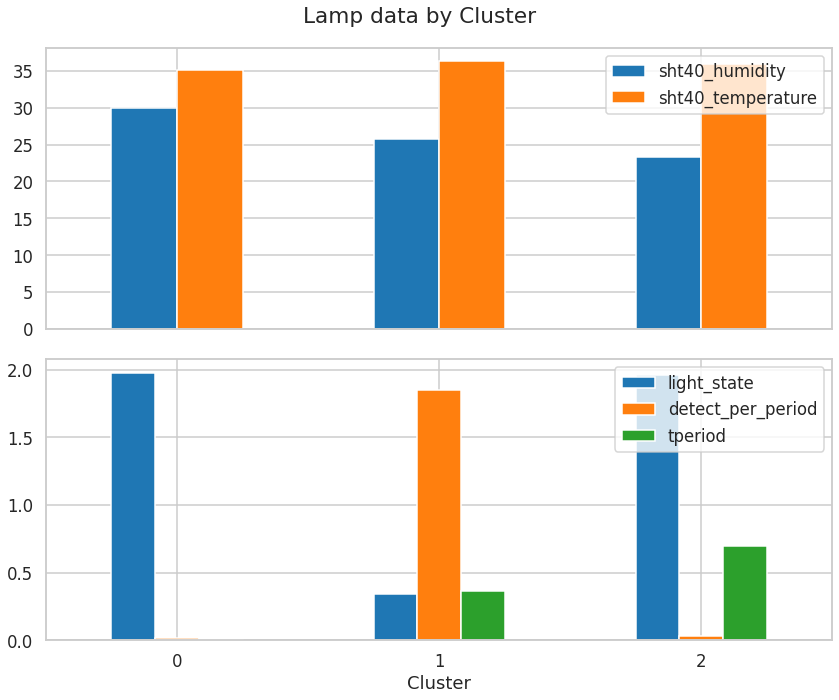

In [ ]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 10))
plotcol1 = ["sht40_humidity", "sht40_temperature"]
plotcol2 = ["light_state", "detect_per_period", "tperiod"]

df_cluster2[plotcol1].plot(kind='bar', ax=ax[0])
df_cluster2[plotcol2].plot(kind='bar', ax=ax[1])
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.suptitle("Lamp data by Cluster")
plt.tight_layout(rect=[0, 0, 1, 0.95])


In [ ]:
df_cluster3a = df_cluster.groupby(["Cluster", "source_address"], observed=True)[["tperiod"]].count().reset_index()
df_cluster3 = df_cluster3a.pivot(index="Cluster", columns="source_address", values="tperiod")


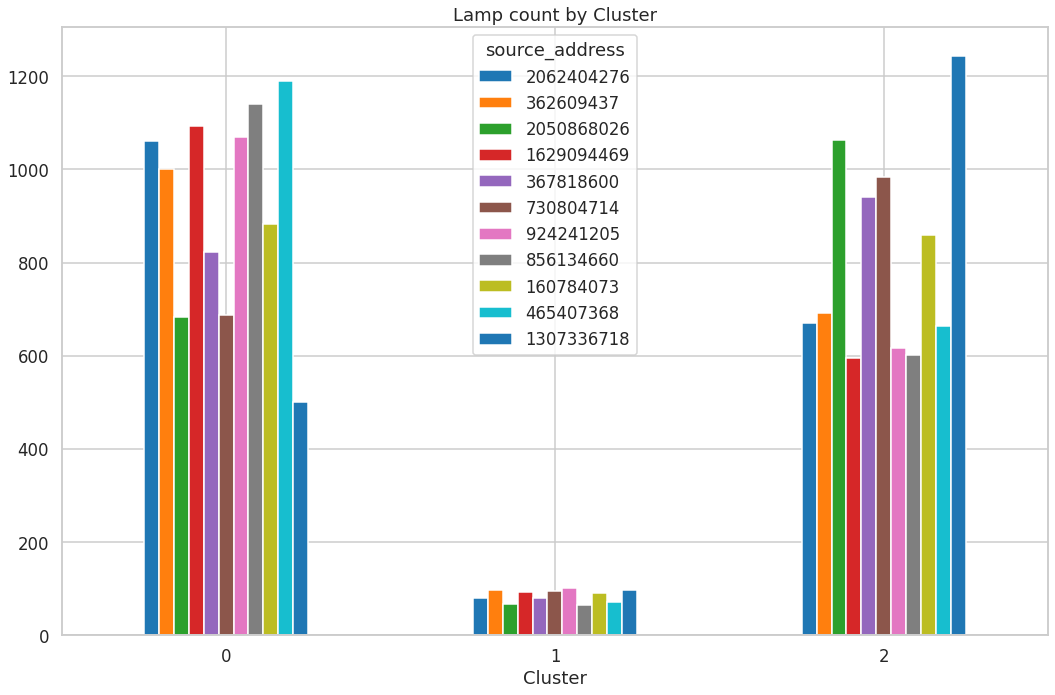

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

df_cluster3.plot(kind='bar', ax=ax)
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.title("Lamp count by Cluster")
plt.tight_layout()

# SENSORS

## K-means

In [21]:
# convert time to datetime then to integer, so that it can be used for clustering
dfsensor_k = dfsensor_c.copy()
dfsensor_c["time"] = pd.to_datetime(dfsensor_c["time"])
dfsensor_k["tperiod"] = (dfsensor_c["time"]>"2022-09-18").astype(int)
dfsensor_k["timeint"] = dfsensor_c["time"].values.astype(np.int64) // 10 ** 9

In [22]:
dfsensor_cluster = dfsensor_k.copy()
dfsensor_cluster = dfsensor_k.drop(columns=["time"]).sample(n=20000, axis=0, random_state=18).reset_index(drop=True)
X = dfsensor_cluster.values
X.shape

(20000, 6)

In [23]:
dfsensor_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   source_address     20000 non-null  category
 1   shtc3_humidity     20000 non-null  float64 
 2   shtc3_temperature  20000 non-null  float64 
 3   x_position         20000 non-null  int64   
 4   tperiod            20000 non-null  int64   
 5   timeint            20000 non-null  int64   
dtypes: category(1), float64(2), int64(3)
memory usage: 801.6 KB


In [ ]:
ss = []
cluster_ranges = range(2, 9)

for K in cluster_ranges:
    # standardize the variables and fit a k-means model
    kmeans_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=K, random_state=18, n_init=100, max_iter=1000))])
    kmeans_pipeline.fit_predict(X)
    # stores the ss errors
    ss.append(kmeans_pipeline.named_steps["cluster"].inertia_)

2
3
4
5
6
7
8


## "Optimal" number of clusters (elbow and silhouette method)

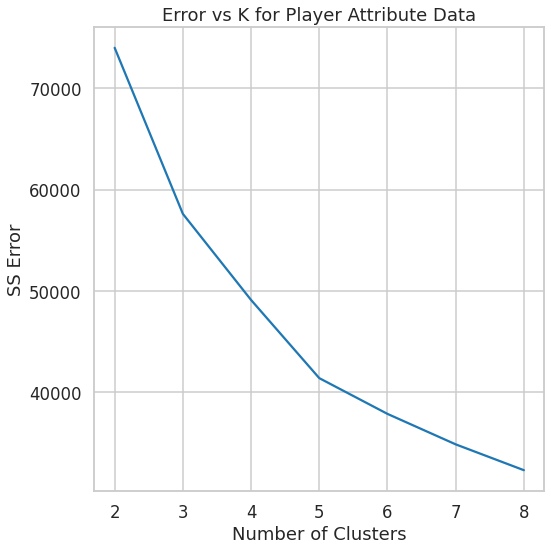

In [ ]:
# Elbow

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.lineplot(x=cluster_ranges, y=ss)
ax.set_title("Error vs K for Player Attribute Data")
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('SS Error')
plt.tight_layout()
plt.show()

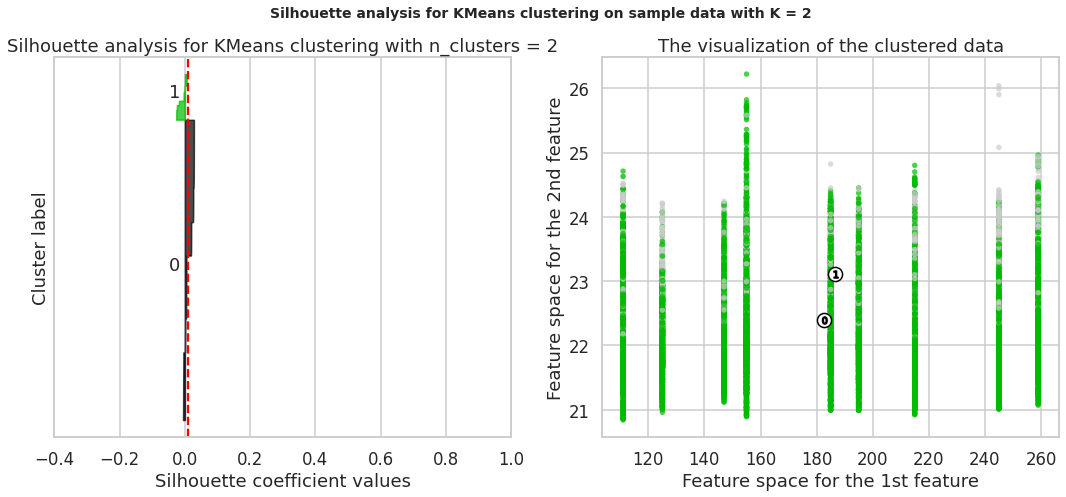

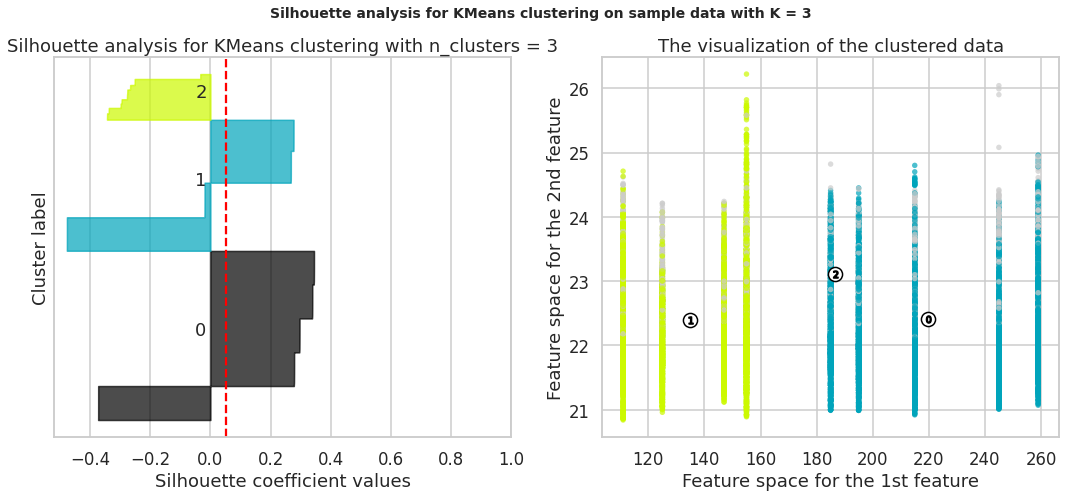

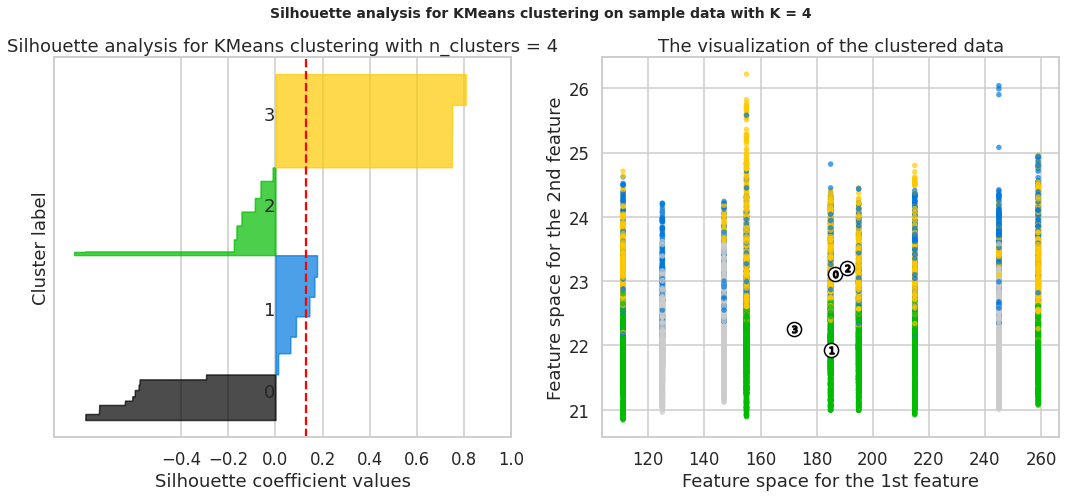

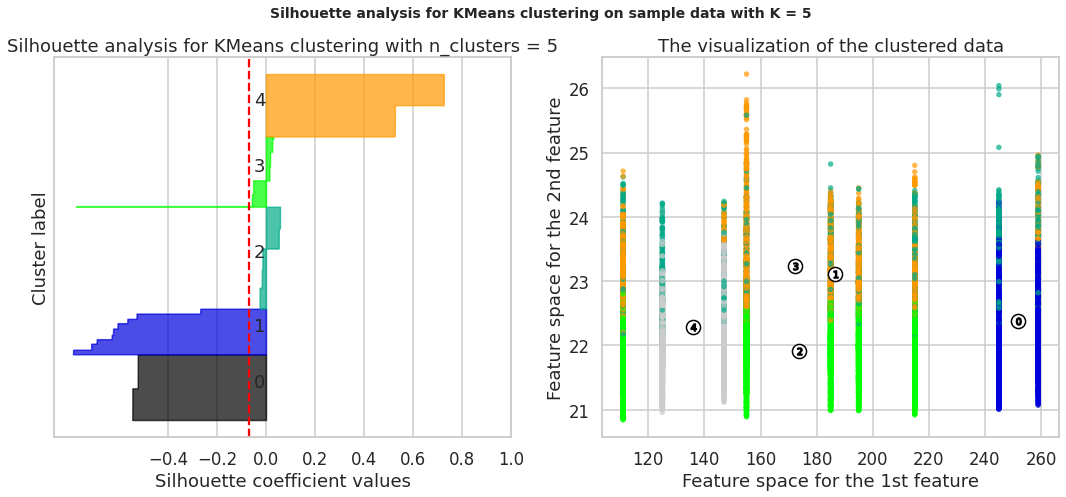

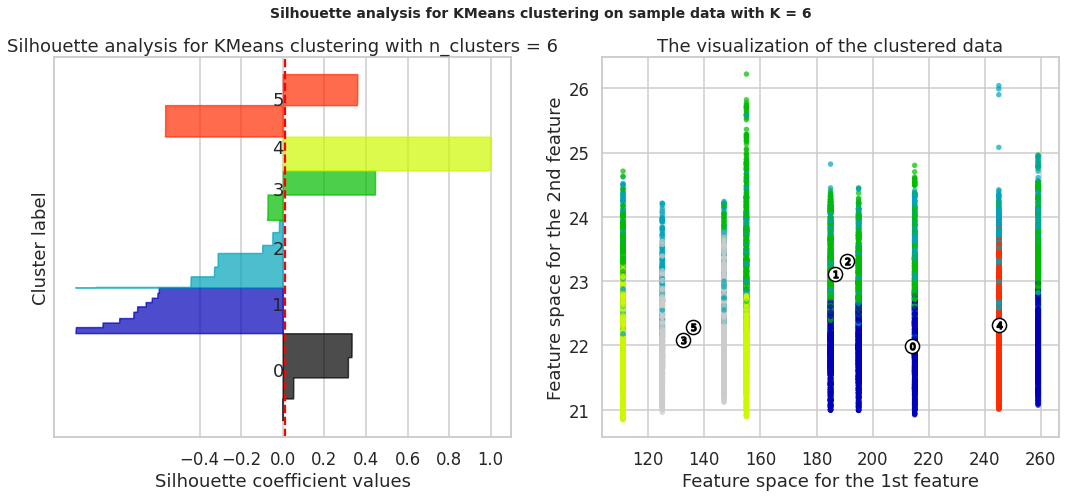

In [ ]:
# Silhouette method

# Code adapted from scikit-learn documentation example

avg_silhouette_scores = []
cluster_ranges = range(2, 7)

# Get rid of warning of too many plots open
plt.rcParams.update({'figure.max_open_warning': 0})

for K in cluster_ranges:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax.set_xlim([-.4, 1])
    # The (K+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility
    kmeans_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=K, random_state=18, n_init=100, max_iter=1000))])

    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = (silhouette_score(X, cluster_labels))
    avg_silhouette_scores.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"Silhouette analysis for KMeans clustering with n_clusters = {K}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / K)
    # to visualize the actual data in a continuous space we use PCA
    ax2.scatter(X[:, 3], X[:, 2], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 3], centers[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[3], c[2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        (
            f"Silhouette analysis for KMeans clustering on sample data with K = {K}"
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
 
plt.show()

### PCA



In [51]:
pca_cols = ["shtc3_humidity", "shtc3_temperature"] 
dfpca = dfsensor_cluster[pca_cols]
X = dfpca.values
X.shape

(20000, 2)

In [67]:
# Standardize the variables first, then calculate top two PCA features
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_std)
x_pca = pca_features[:,0]
y_pca = pca_features[:,1]

K = 3   # use the 3 clusters from elbow method 

kmeans = KMeans(n_clusters=K, random_state=18, n_init=1000, max_iter=10000)
cl_labels = kmeans.fit_predict(X_std)
df_pca_features = pd.DataFrame({"cluster_id": cl_labels, 
                                "pc_1": x_pca, 
                                "pc_2": y_pca})
df_pca_features

,cluster_id,pc_1,pc_2
0,1,0.375199,0.087736
1,0,1.035201,-1.064155
2,1,0.159292,0.209049
3,2,-0.995006,1.174159
4,1,1.201878,1.758336
...,...,...,...
19995,0,3.344249,0.353798
19996,1,0.578495,1.454699
19997,2,-0.174232,-0.800660
19998,0,2.272499,-1.563620


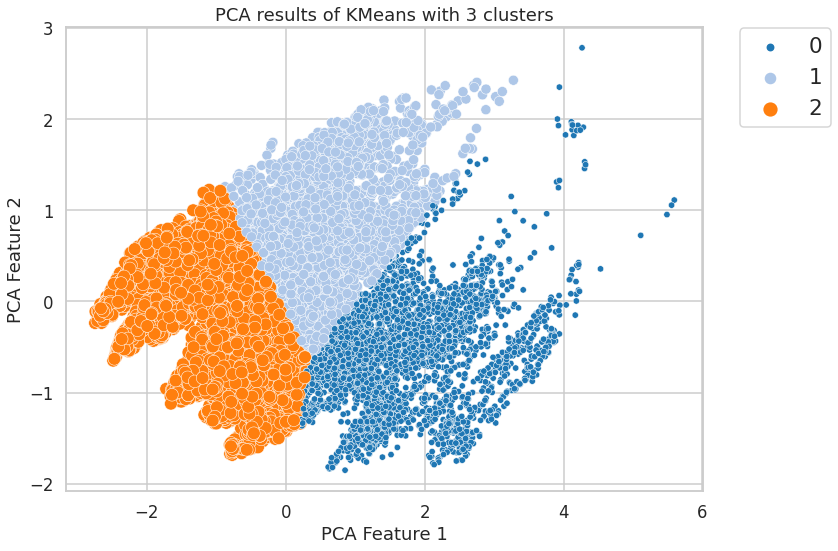

In [68]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(x="pc_1", y="pc_2", 
                hue="cluster_id", 
                size="cluster_id", 
                data=df_pca_features, 
                palette="tab20", 
                legend="full")
ax.set_xlabel("PCA Feature 1")
ax.set_ylabel("PCA Feature 2")
ax.set_title("PCA results of KMeans with " + str(K) + " clusters")
ax.legend(bbox_to_anchor=(1.04,1.02), loc="upper left", fontsize="large")
plt.tight_layout()
plt.show()

In [69]:
# merge cluster to position dataframe
df_cluster = pd.concat([dfsensor_cluster, pd.DataFrame(cl_labels, columns=["Cluster"])], axis=1)
df_cluster

,source_address,shtc3_humidity,shtc3_temperature,x_position,tperiod,timeint,Cluster
0,1786944289,53.80,22.74,259,0,1661241934,1
1,2099571705,43.43,22.48,215,1,1664948742,0
2,614953587,55.73,22.69,125,0,1660734005,1
3,1916751226,67.86,22.59,111,0,1662539911,2
4,1566931549,58.63,24.06,155,0,1661781906,1
...,...,...,...,...,...,...,...
19995,1566931549,38.33,24.45,155,1,1663936338,0
19996,1786944289,60.46,23.57,259,0,1661780750,1
19997,926036168,51.86,21.98,245,0,1661379420,2
19998,2132706098,33.49,22.87,185,1,1663720096,0


In [70]:
df_cluster2 = df_cluster.groupby(["Cluster"]).mean()
df_cluster2

,shtc3_humidity,shtc3_temperature,x_position,tperiod,timeint
Cluster,,,,,
0,42.630792,23.057916,185.948731,0.671932,1.663407e+09
1,56.725670,23.087818,184.706621,0.004550,1.661719e+09
2,59.677905,21.885975,181.021508,0.001331,1.661492e+09


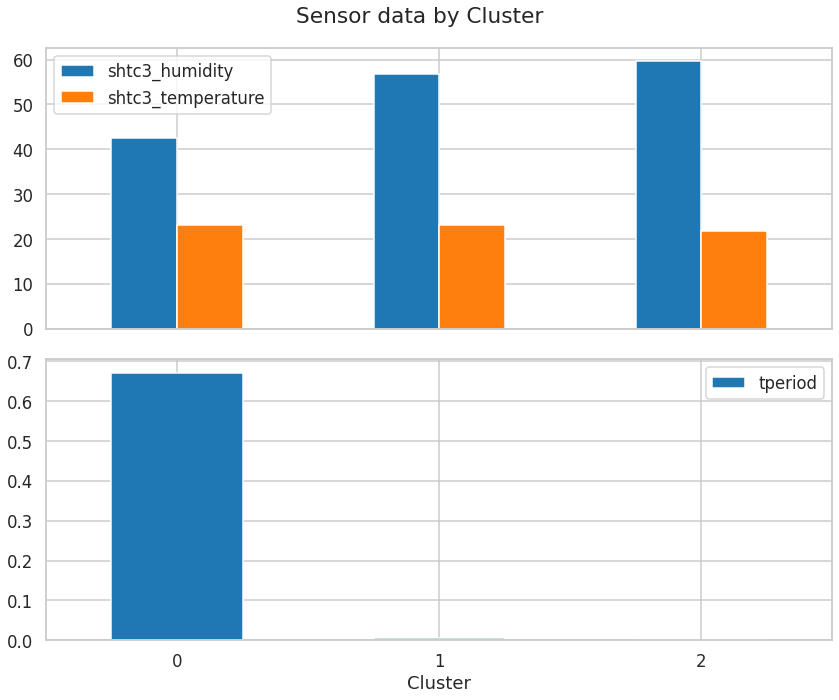

In [71]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 10))
plotcol1 = ["shtc3_humidity", "shtc3_temperature"]
plotcol2 = ["tperiod"]

df_cluster2[plotcol1].plot(kind='bar', ax=ax[0])
df_cluster2[plotcol2].plot(kind='bar', ax=ax[1])
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.suptitle("Sensor data by Cluster")
plt.tight_layout(rect=[0, 0, 1, 0.95])


In [72]:
df_cluster3a = df_cluster.groupby(["Cluster", "source_address"], observed=True)[["tperiod"]].count().reset_index()
df_cluster3 = df_cluster3a.pivot(index="Cluster", columns="source_address", values="tperiod")


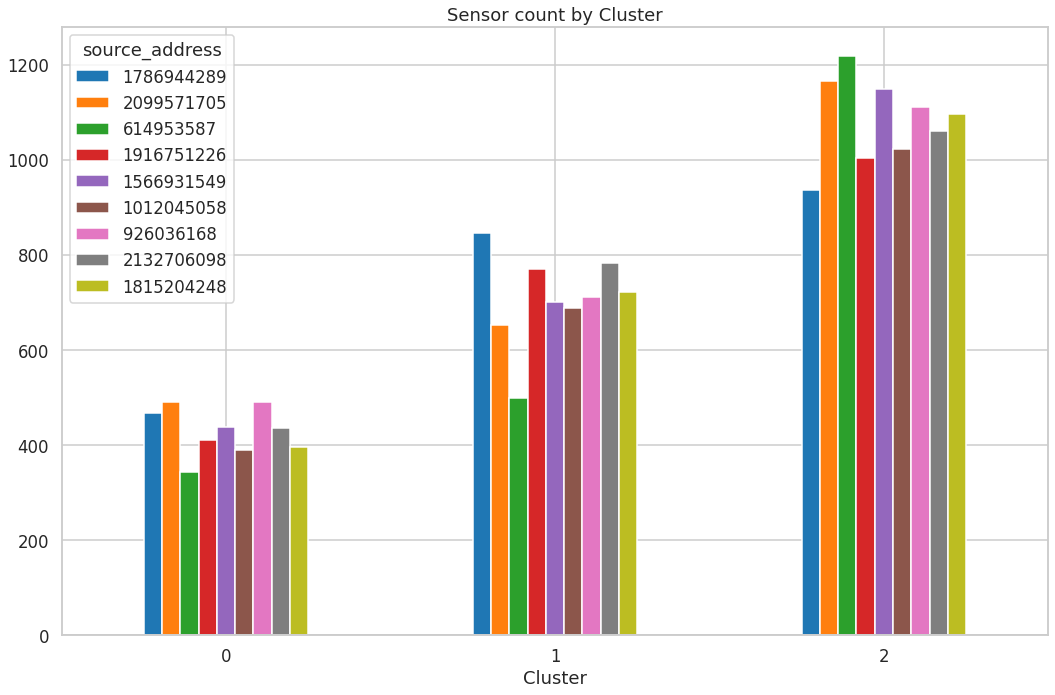

In [73]:
fig, ax = plt.subplots(figsize=(15, 10))

df_cluster3.plot(kind='bar', ax=ax)
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.title("Sensor count by Cluster")
plt.tight_layout()

## Hierarchical clustering (Agglomerative clustering)

In [37]:
model_sensor = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model_sensor = model_sensor.fit(X)
model_sensor.n_clusters_

20000

In [47]:
model_sensor = AgglomerativeClustering(distance_threshold=10, n_clusters=None)
model_sensor = model_sensor.fit(X)
model_sensor.n_clusters_

74

The observations are split into many clusters, so there is not a clear indication of outliers among the sensors. 

# LAMPS AND SENSORS COMBINED

## K-means

In [24]:
dflamp_com = dflamp_k.copy()
dflamp_com = dflamp_k.rename(columns={"sht40_humidity": "humidity", "sht40_temperature": "temperature"})
dflamp_com = dflamp_com[["timeint", "tperiod", "source_address", "humidity", "temperature", "x_position"]]
dflamp_com["device"] = 1
dflamp_com.describe()

,timeint,tperiod,humidity,temperature,x_position,device
count,7.862890e+05,786289.000000,786289.000000,786289.000000,786289.000000,786289.0
mean,1.662707e+09,0.328627,26.805737,35.518448,185.001068,1.0
std,1.329845e+06,0.469714,4.545625,0.790681,47.147908,0.0
min,1.660522e+09,0.000000,15.030000,33.220000,111.000000,1.0
25%,1.661576e+09,0.000000,23.430000,34.960000,140.000000,1.0
50%,1.662580e+09,0.000000,27.100000,35.490000,185.000000,1.0
75%,1.663969e+09,1.000000,30.500000,36.010000,230.000000,1.0
max,1.665014e+09,1.000000,37.480000,38.950000,259.000000,1.0


In [25]:
dfsensor_com = dfsensor_k.copy()
dfsensor_com = dfsensor_k.rename(columns={"shtc3_humidity": "humidity", "shtc3_temperature": "temperature"})
dfsensor_com = dfsensor_com[["timeint", "tperiod", "source_address", "humidity", "temperature", "x_position"]]
dfsensor_com["device"] = 2
dfsensor_com

,timeint,tperiod,source_address,humidity,temperature,x_position,device
0,1660521615,0,1786944289,48.94,22.07,259,2
1,1660521625,0,614953587,49.73,21.82,125,2
2,1660521626,0,926036168,49.50,21.91,245,2
3,1660521634,0,2132706098,49.31,21.81,185,2
4,1660521635,0,2099571705,49.73,21.84,215,2
...,...,...,...,...,...,...,...
1171707,1665014239,1,2132706098,45.13,22.80,185,2
1171708,1665014277,1,926036168,45.72,22.81,245,2
1171709,1665014287,1,2099571705,45.73,22.79,215,2
1171721,1665014302,1,1566931549,46.30,22.73,155,2


In [26]:
df_com = pd.concat([dflamp_com, dfsensor_com], axis=0)
df_com

,timeint,tperiod,source_address,humidity,temperature,x_position,device
27,1660521708,0,856134660,25.59,34.50,259,1
28,1660521708,0,2050868026,25.55,34.74,215,1
29,1660521708,0,1629094469,25.62,34.78,155,1
30,1660521708,0,730804714,26.13,34.49,170,1
31,1660521708,0,160784073,25.81,34.14,230,1
...,...,...,...,...,...,...,...
1171707,1665014239,1,2132706098,45.13,22.80,185,2
1171708,1665014277,1,926036168,45.72,22.81,245,2
1171709,1665014287,1,2099571705,45.73,22.79,215,2
1171721,1665014302,1,1566931549,46.30,22.73,155,2


In [27]:
dfcom_cluster = df_com.copy()
dfcom_cluster = df_com.sample(n=40000, axis=0, random_state=18).reset_index(drop=True)
X = dfcom_cluster.values
X.shape

(40000, 7)

In [28]:
dfcom_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   timeint         40000 non-null  int64   
 1   tperiod         40000 non-null  int64   
 2   source_address  40000 non-null  category
 3   humidity        40000 non-null  float64 
 4   temperature     40000 non-null  float64 
 5   x_position      40000 non-null  int64   
 6   device          40000 non-null  int64   
dtypes: category(1), float64(2), int64(4)
memory usage: 1.9 MB


In [ ]:
ss = []
cluster_ranges = range(2, 9)

for K in cluster_ranges:
    # standardize the variables and fit a k-means model
    kmeans_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("cluster", KMeans(n_clusters=K, random_state=18, n_init=100, max_iter=1000))])
    kmeans_pipeline.fit_predict(X)
    # stores the ss errors
    ss.append(kmeans_pipeline.named_steps["cluster"].inertia_)

2
3
4
5
6
7
8


## "Optimal" number of clusters (elbow and silhouette method)

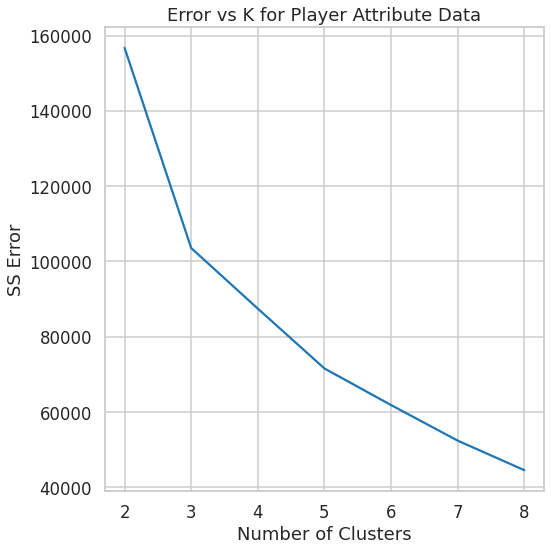

In [ ]:
# Elbow

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.lineplot(x=cluster_ranges, y=ss)
ax.set_title("Error vs K for Player Attribute Data")
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('SS Error')
plt.tight_layout()
plt.show()

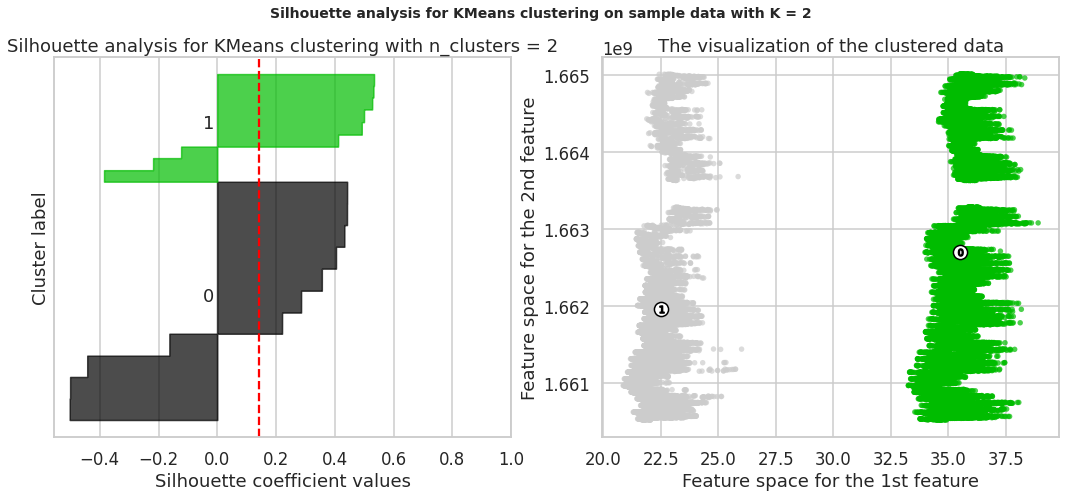

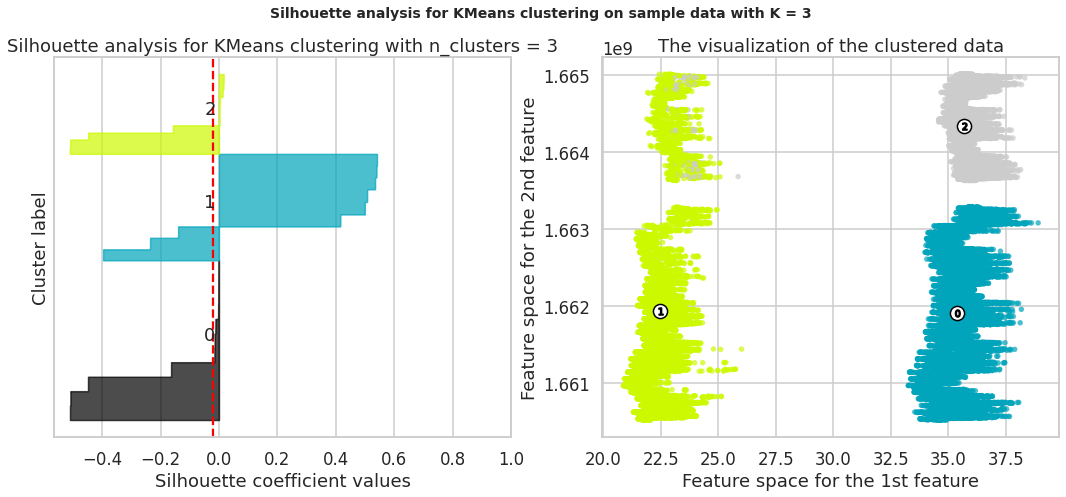

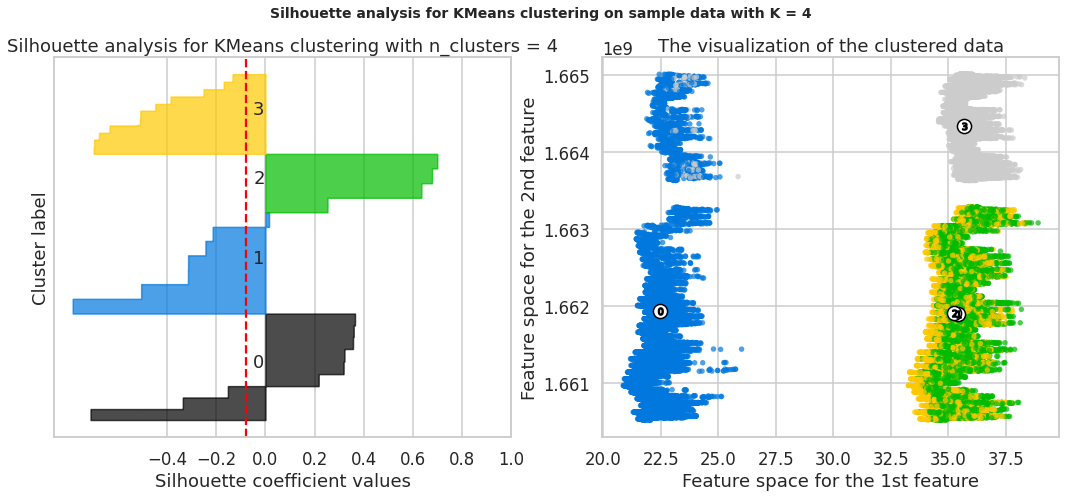

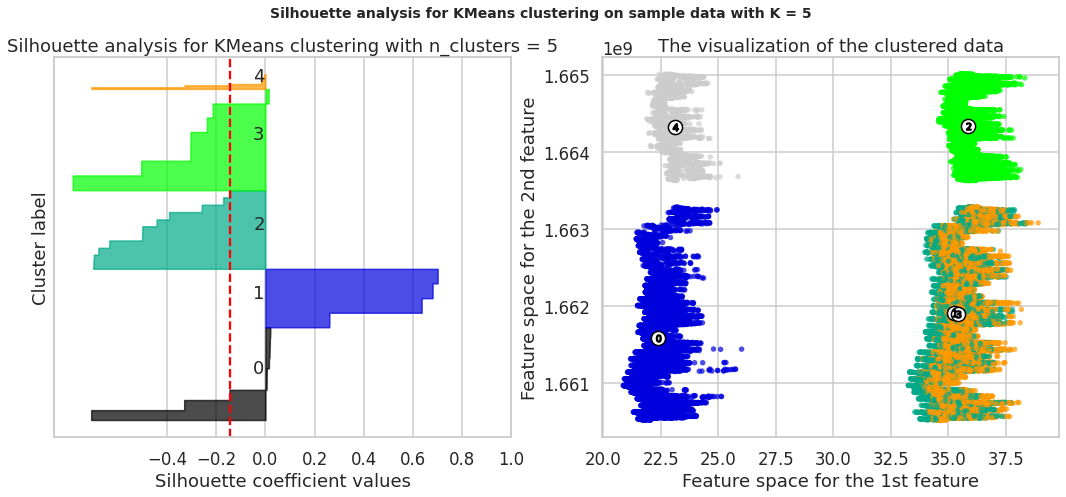

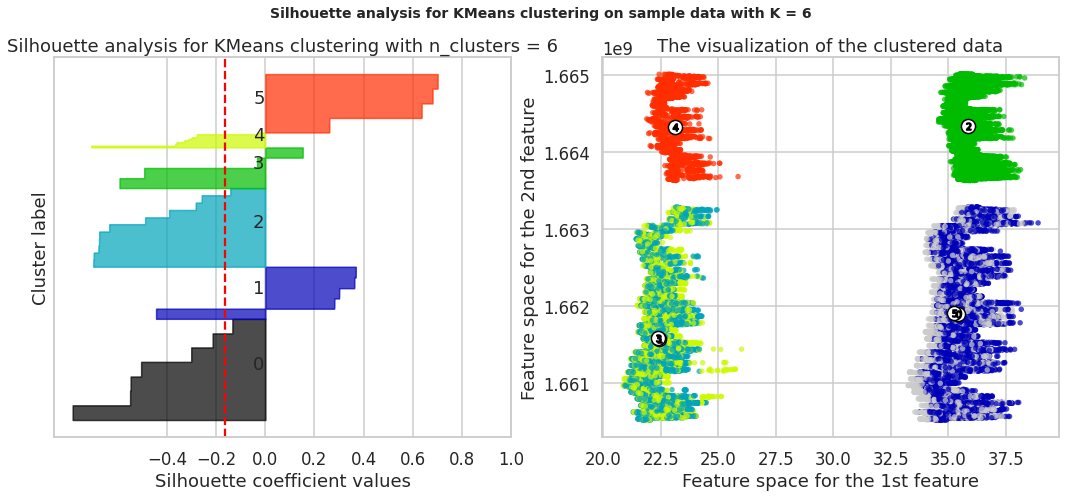

In [ ]:
# Silhouette method

# Code adapted from scikit-learn documentation example

avg_silhouette_scores = []
cluster_ranges = range(2, 7)

# Get rid of warning of too many plots open
plt.rcParams.update({'figure.max_open_warning': 0})

for K in cluster_ranges:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax.set_xlim([-.4, 1])
    # The (K+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the Pipeline with n_clusters value and a random generator seed for reproducibility
    kmeans_pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("cluster", KMeans(n_clusters=K, random_state=18, n_init=100, max_iter=1000))])

    cluster_labels = kmeans_pipeline.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = (silhouette_score(X, cluster_labels))
    avg_silhouette_scores.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"Silhouette analysis for KMeans clustering with n_clusters = {K}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / K)
    # to visualize the actual data in a continuous space we use PCA
    ax2.scatter(X[:, 4], X[:, 0], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    pipeline_centers = kmeans_pipeline.named_steps["cluster"].cluster_centers_
    centers = kmeans_pipeline.named_steps["scaler"].inverse_transform(pipeline_centers)

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 4], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[4], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        (
            f"Silhouette analysis for KMeans clustering on sample data with K = {K}"
        ),
        fontsize=14,
        fontweight="bold",
    )
print("\n")
 
plt.show()

### PCA



In [29]:
pca_cols = ["temperature", "humidity"] 
dfpca = dfcom_cluster[pca_cols]
dfid = dfcom_cluster.drop(columns=pca_cols)
X = dfpca.values
X.shape

(40000, 2)

In [30]:
# Standardize the variables first, then calculate top two PCA features
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X_std)
x_pca = pca_features[:,0]
y_pca = pca_features[:,1]

K = 3   # use the 3 clusters from elbow method 

kmeans = KMeans(n_clusters=K, random_state=18, n_init=1000, max_iter=10000)
cl_labels = kmeans.fit_predict(X_std)
df_pca_features = pd.DataFrame({"cluster_id": cl_labels, 
                                "pc_1": x_pca, 
                                "pc_2": y_pca})
df_pca_features

,cluster_id,pc_1,pc_2
0,1,-0.751054,-0.224300
1,0,2.131880,-0.192320
2,1,-0.842914,-0.327853
3,0,2.256556,-0.263490
4,0,2.169921,0.016232
...,...,...,...
39995,1,-1.186929,0.267407
39996,1,-0.526855,-0.411278
39997,1,-0.435194,-0.267977
39998,1,-0.759740,-0.022527


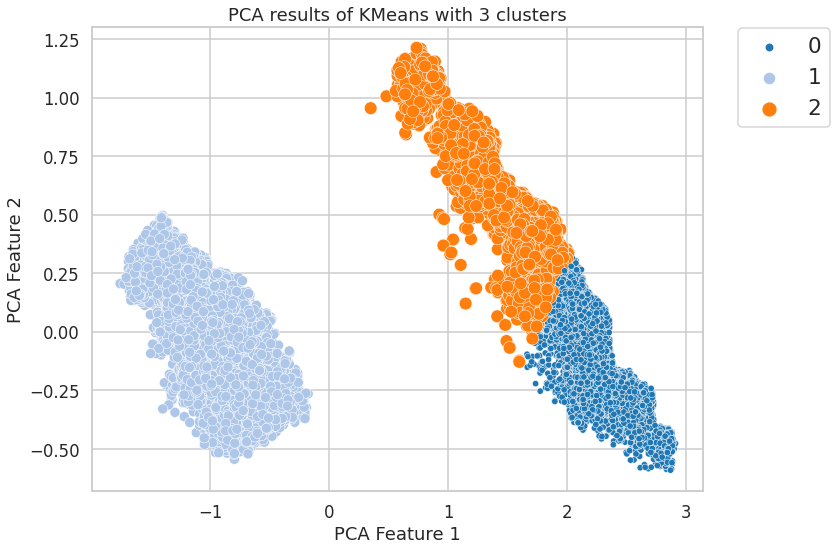

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(x="pc_1", y="pc_2", 
                hue="cluster_id", 
                size="cluster_id", 
                data=df_pca_features, 
                palette="tab20", 
                legend="full")
ax.set_xlabel("PCA Feature 1")
ax.set_ylabel("PCA Feature 2")
ax.set_title("PCA results of KMeans with " + str(K) + " clusters")
ax.legend(bbox_to_anchor=(1.04,1.02), loc="upper left", fontsize="large")
plt.tight_layout()
plt.show()

In [32]:
# merge cluster to position dataframe
df_cluster = pd.concat([dfcom_cluster, pd.DataFrame(cl_labels, columns=["Cluster"])], axis=1)
df_cluster

,timeint,tperiod,source_address,humidity,temperature,x_position,device,Cluster
0,1661961765,0,465407368,30.29,35.66,245,1,1
1,1660833344,0,1012045058,59.55,23.13,147,2,0
2,1662378849,0,160784073,30.41,36.50,230,1,1
3,1662447353,0,2132706098,61.56,22.90,185,2,0
4,1662179867,0,1012045058,57.80,22.07,147,2,0
...,...,...,...,...,...,...,...,...
39995,1664247788,1,856134660,20.77,35.42,259,1,1
39996,1662537230,0,1307336718,34.51,35.50,200,1,1
39997,1660930132,0,2050868026,33.98,34.49,215,1,1
39998,1662692868,0,2062404276,28.13,34.83,111,1,1


In [34]:
df_cluster2 = df_cluster.groupby(["Cluster"]).mean()
df_cluster2

,timeint,tperiod,humidity,temperature,x_position,device
Cluster,,,,,,
0,1.661608e+09,0.000000,60.219472,22.314344,181.553521,2.0
1,1.662708e+09,0.329910,26.787471,35.519019,185.165844,1.0
2,1.662629e+09,0.398653,46.363195,22.837358,185.461574,2.0


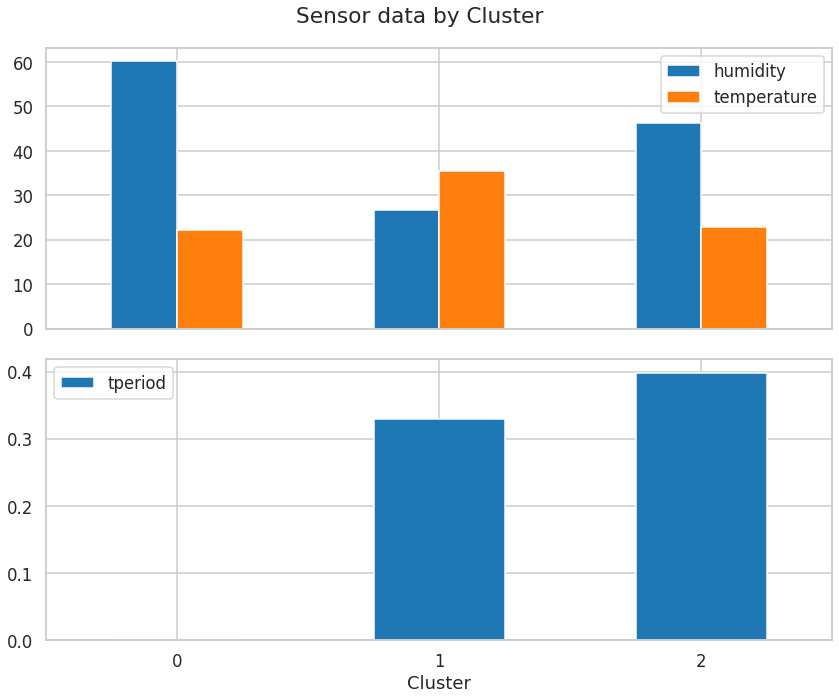

In [35]:
fig, ax = plt.subplots(2, sharex=True, figsize=(12, 10))
plotcol1 = ["humidity", "temperature"]
plotcol2 = ["tperiod"]

df_cluster2[plotcol1].plot(kind='bar', ax=ax[0])
df_cluster2[plotcol2].plot(kind='bar', ax=ax[1])
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.suptitle("Device data by Cluster")
plt.tight_layout(rect=[0, 0, 1, 0.95])


In [36]:
df_cluster3a = df_cluster.groupby(["Cluster", "source_address"], observed=True)[["tperiod"]].count().reset_index()
df_cluster3 = df_cluster3a.pivot(index="Cluster", columns="source_address", values="tperiod")


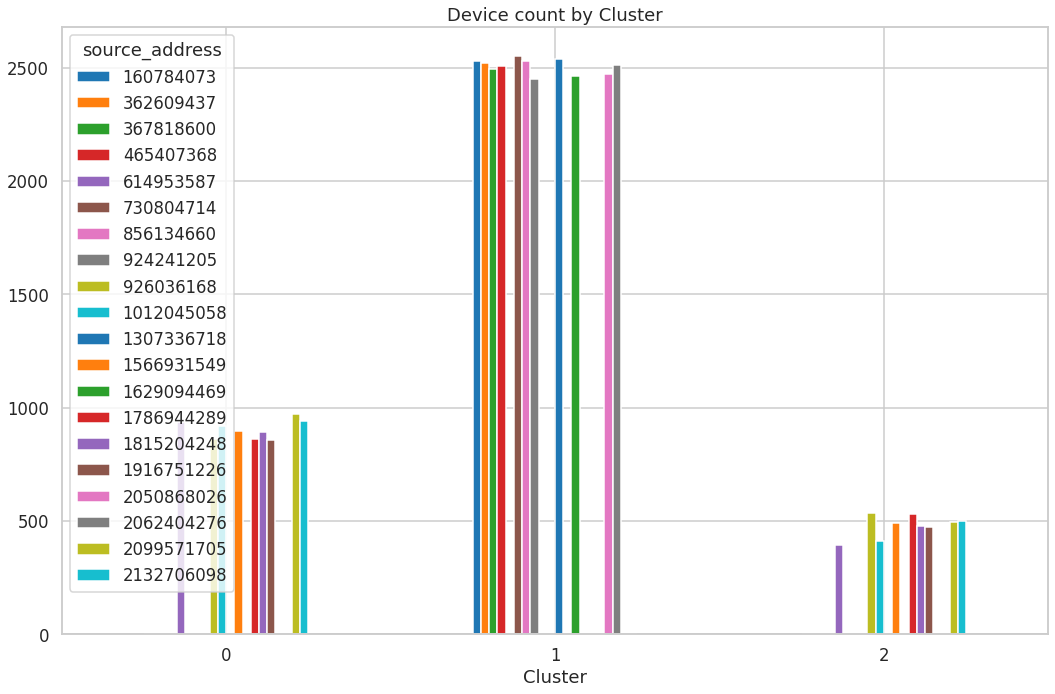

In [38]:
fig, ax = plt.subplots(figsize=(15, 10))

df_cluster3.plot(kind='bar', ax=ax)
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.title("Device count by Cluster")
plt.tight_layout()

## Hierarchical clustering (Agglomerative clustering)

In [ ]:
model_combine = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model_combine = model_combine.fit(X)
model_combine.n_clusters_

In [ ]:
model_combine = AgglomerativeClustering(distance_threshold=10, n_clusters=None)
model_combine = model_combine.fit(X)
model_combine.n_clusters_

74

The observations are split into many clusters, so there is not a clear indication of outliers among the sensors. 